<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v19_layerOutputStats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Visualisations v19: Layer Output Stats
I've just discovered a fairly major bug in the calculations of value and magnitude stats against layer outputs and their gradients.

I've been trying to treat the layer outputs like the way that gradients work - a single value averaged over the batch. Worse yet, I've extended that in the same way I've extend gradients to epochs - so that I further average over the epoch. This effectively results in a single model output vector, that is simply the mean over all samples in the training set. If it's a binary classification or single-variable regression model, then you get a scalar.

But that's simply not how layer outputs work. I need to compute the stats over the entire population of the training set.

What we've got so far and what we need for layer outputs:

|Quantity|Current State|Required State|
|--|--|--|
|Value stats|Taken from mean over all samples|Calculated or estimated directly over all samples|
|Magnitude stats|Taken from mean over all samples|Calculated or estimated directly over all samples|
|Norm|Calculated on mean over all samples|?|
|Activity rates|Calculated directly over all samples|no change|
|Raw value collection|According to batchReduction mode|No change to epoch mode. No other meaningful outcome|

And for layer output gradients, which also have the batch dimension:

* Apply same rules, because I don't know what else to do.

But first, I need to figure out how to even accumulate distribution data over the samples in an epoch.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git repo

# lock to revision
#!cd repo && git checkout f289e95
!cd repo && git pull

import sys
sys.path.append('repo')

import train_instrumentation as tinstr
from importlib import reload
reload(tinstr)

Cloning into 'repo'...
remote: Enumerating objects: 1479, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1479 (delta 25), reused 14 (delta 9), pack-reused 1440 (from 2)
Receiving objects: 100% (1479/1479), 155.83 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (882/882), done.
Updating files: 100% (23/23), done.
Already up to date.


<module 'train_instrumentation' from '/content/repo/train_instrumentation.py'>

In [2]:
import train_instrumentation_test
reload(train_instrumentation_test)
reload(tinstr)
train_instrumentation_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
!pip install tdigest
!pip install fastdigest
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm
import tdigest
import fastdigest

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.4-cp311-cp311-linux_x86_64.whl size=385058 sha256=86b8bb7c915b7892eb9fea0a2cb2501aa74ec78901e6f3c3fbfdef32dd79cf05
  Stored in directory: /root/.cache/pip/wheels/e9/e7/ee/2d9f17d273e58197be57a017c6f0d7e97a68d8fbe73e472dcb
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-py3-none-any.whl size=2191 sha256=efb7d39794cc425d15196098b3f7cc86c7abf530ada681e7a5a865be4f155d13
  Stored in directory: /root/.cache/pip/wheels/a5/6d/e9/29f0512b6cb296c100b7459c6c5e0f62deb0451e07a0a70874
Successfully built accumulation-tree pyudorandom
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 kB 12.9 MB/s eta 0:00:00


## Exploring distribution aggregation options: Data Collection
The biggest issue is where the distributions are far from gaussian. So I'll experiment on gradients for the main experiments. I'll also experiment on the layer outputs from a small model, to check that any solution I come up with works on small tensor sizes too.

The first step is to collect some data that we can experiment with.
Just generating it won't be so good, as the shape of the data has a strong effect.

In [4]:
def binary_classification_dataset():
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, factor=0.5, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  return train_X, train_Y

# this model comes from https://github.com/malcolmlett/training-instrumentation-toolkit/blob/main/doc/blog-202503/vanishing-and-exploding-gradients.ipynb
def binary_classification_model():
    return tf.keras.Sequential([
        layers.Input(shape=(2,), name="input"),
        layers.Dense(5, activation="sigmoid", kernel_initializer="glorot_uniform", name="dense1"),
        layers.BatchNormalization(name="batchNorm1"),
        layers.Dense(5, activation="sigmoid", kernel_initializer="glorot_uniform", name="dense2"),
        layers.BatchNormalization(name="batchNorm2"),
        layers.Dense(5, activation="sigmoid", kernel_initializer="glorot_uniform", name="dense3"),
        layers.BatchNormalization(name="batchNorm3"),
        layers.Dense(5, activation="sigmoid", kernel_initializer="glorot_uniform", name="dense4"),
        layers.BatchNormalization(name="batchNorm4"),
        layers.Dense(1, activation="sigmoid", kernel_initializer="he_normal", name="class")
    ])

def mnist_dataset():
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

  # Normalize the data and just take the first 5000 images to speed up training
  x_train = x_train[0:5000] / 255.0
  y_train = y_train[0:5000]
  return x_train, y_train

def mnist_classification_model():
  inp = tf.keras.layers.Input((28, 28), name="input")
  x = tf.keras.layers.Reshape((28,28,1), name="reshape")(inp)

  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', name="conv1a")(x)
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', name="conv1b")(x)
  x = layers.BatchNormalization(name="batchNorm1")(x)
  x = tf.keras.layers.MaxPool2D(pool_size=2, padding='valid', name="pool1")(x)
  x = layers.Dropout(0.2, name="dropout1")(x)

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', name="conv2a")(x)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', name="conv2b")(x)
  x = layers.BatchNormalization(name="batchNorm2")(x)
  x = tf.keras.layers.MaxPool2D(pool_size=2, padding='valid', name="pool2")(x)
  x = layers.Dropout(0.2, name="dropout2")(x)

  x = tf.keras.layers.Flatten(name="flatten")(x)
  x = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal', name="dense1")(x)
  x = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal', name="dense2")(x)
  x = tf.keras.layers.Dense(units=10, kernel_initializer='glorot_normal', name="logits")(x)
  return tf.keras.Model(inputs=inp, outputs=x)

In [6]:
# train binary classification model
bc_gradients = tinstr.GradientHistoryCallback(per_step=True, collection_sets=[{}])
bc_outputs = tinstr.LayerOutputHistoryCallback(per_step=True, collection_sets=[{}])
bc_output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=[{}])

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_X, train_Y = binary_classification_dataset()
bc_history = tinstr.fit(model, train_X, train_Y, batch_size=32, epochs=2,
                        callbacks=[tinstr.HistoryStats(per_step=True), bc_gradients, bc_outputs, bc_output_gradients])

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - accuracy: 0.5628 - loss: 0.6887
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5359 - loss: 0.6994


In [5]:
# train mnist classification model
mn_gradients = tinstr.GradientHistoryCallback(per_step=True, collection_sets=[{'layer_indices': [3, 6]}])
mn_outputs = tinstr.LayerOutputHistoryCallback(per_step=True, collection_sets=[{'layer_indices': [3, 6]}])
mn_output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=[{'layer_indices': [3, 6]}])

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
mn_history = tinstr.fit(model, train_dataset, epochs=2,
                     callbacks=[mn_gradients, mn_outputs, mn_output_gradients, tinstr.HistoryStats(per_step=True)])

# PS: any tf.function retracing warnings can be safely ignored.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.6373 - loss: 1.1527
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.9293 - loss: 0.2399


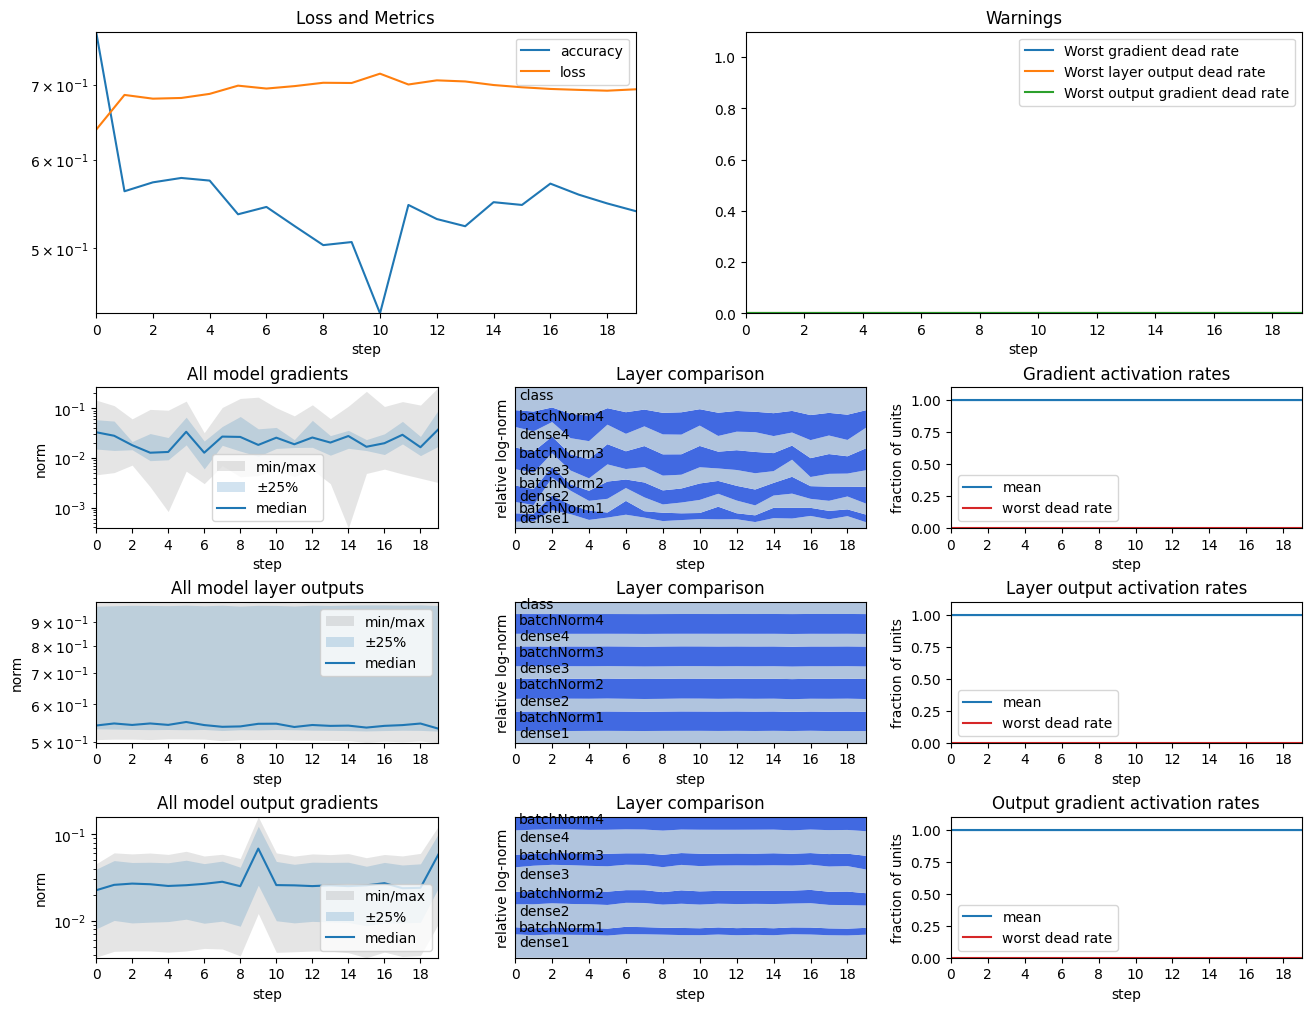

In [7]:
tinstr.plot_history_overview([bc_history, bc_gradients, bc_outputs, bc_output_gradients])

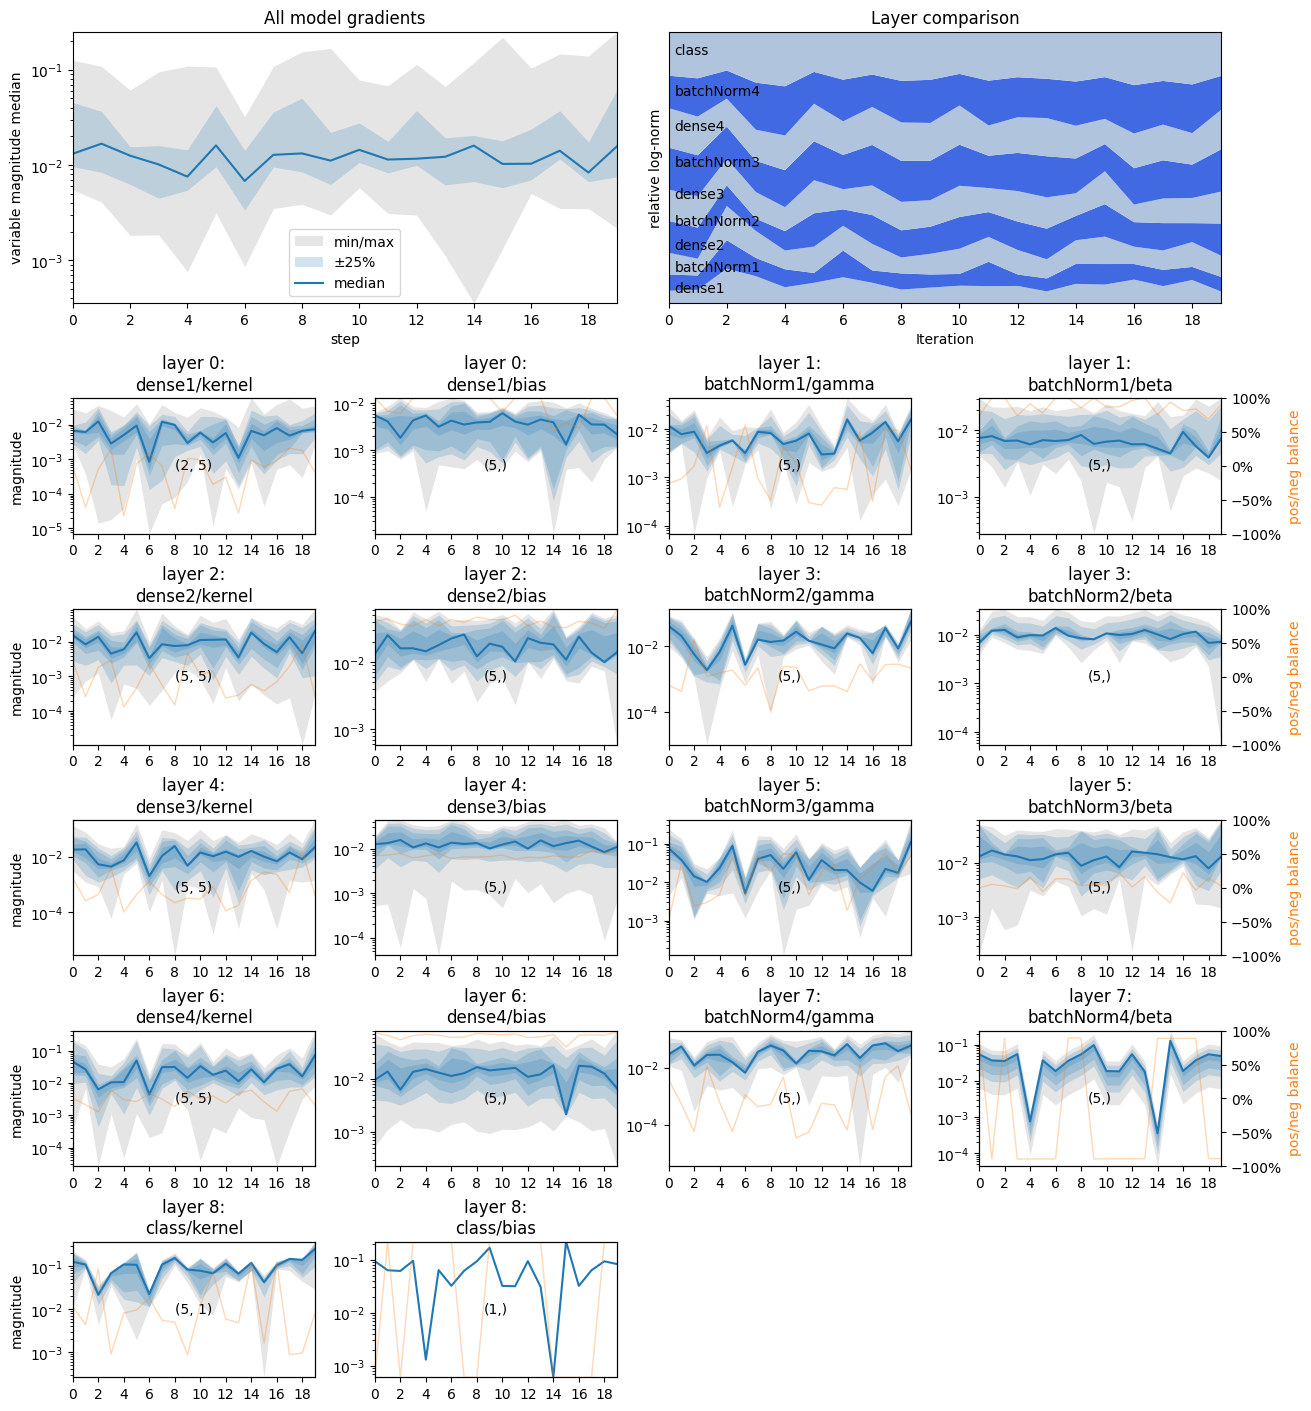

In [8]:
tinstr.plot_value_history(bc_gradients)

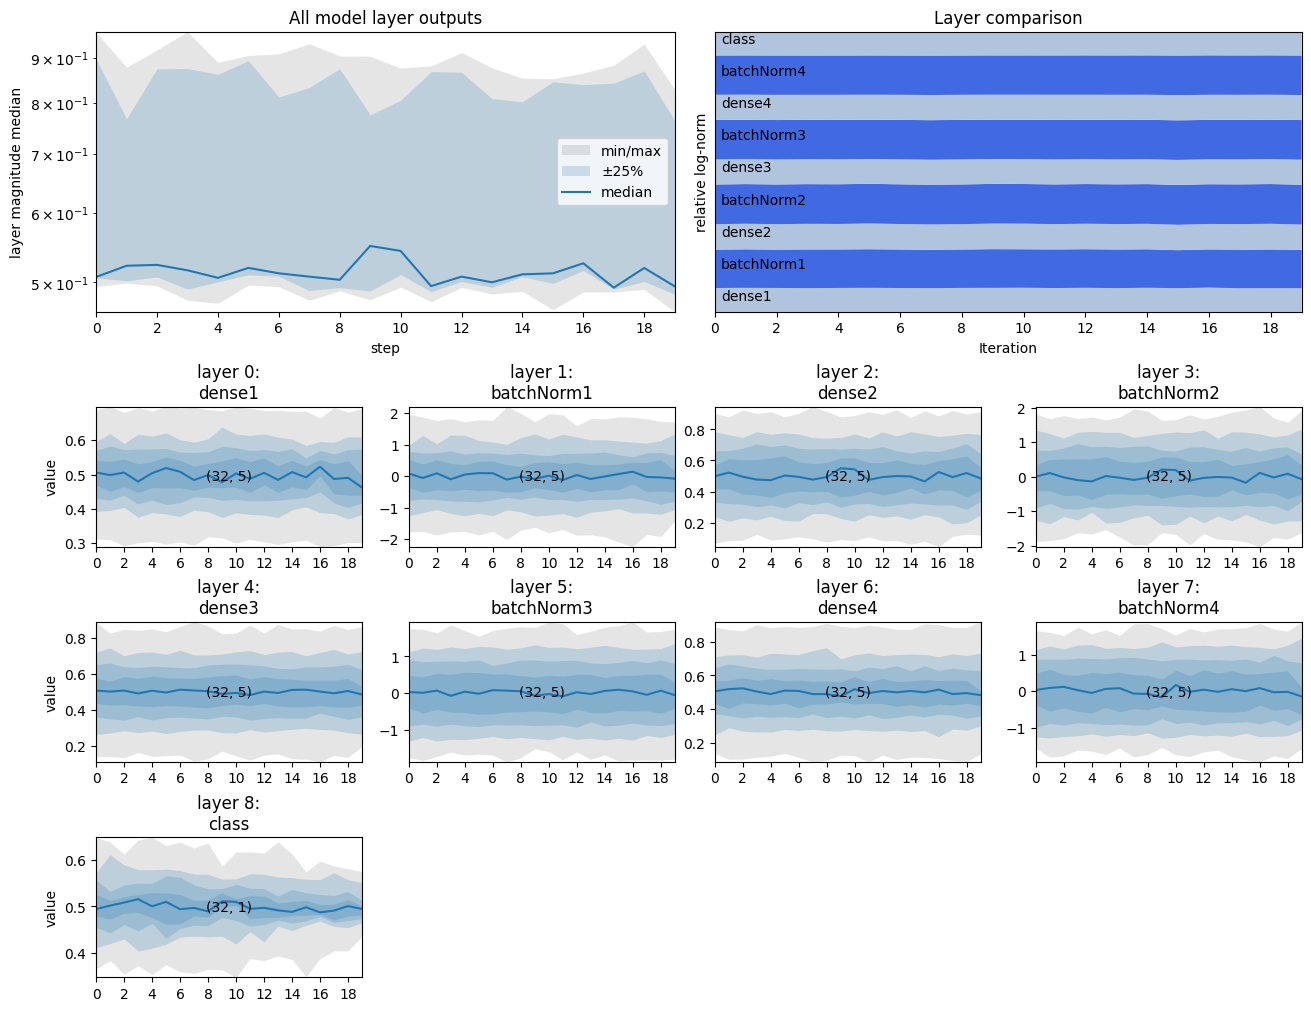

In [14]:
tinstr.plot_value_history(bc_outputs, show='values')

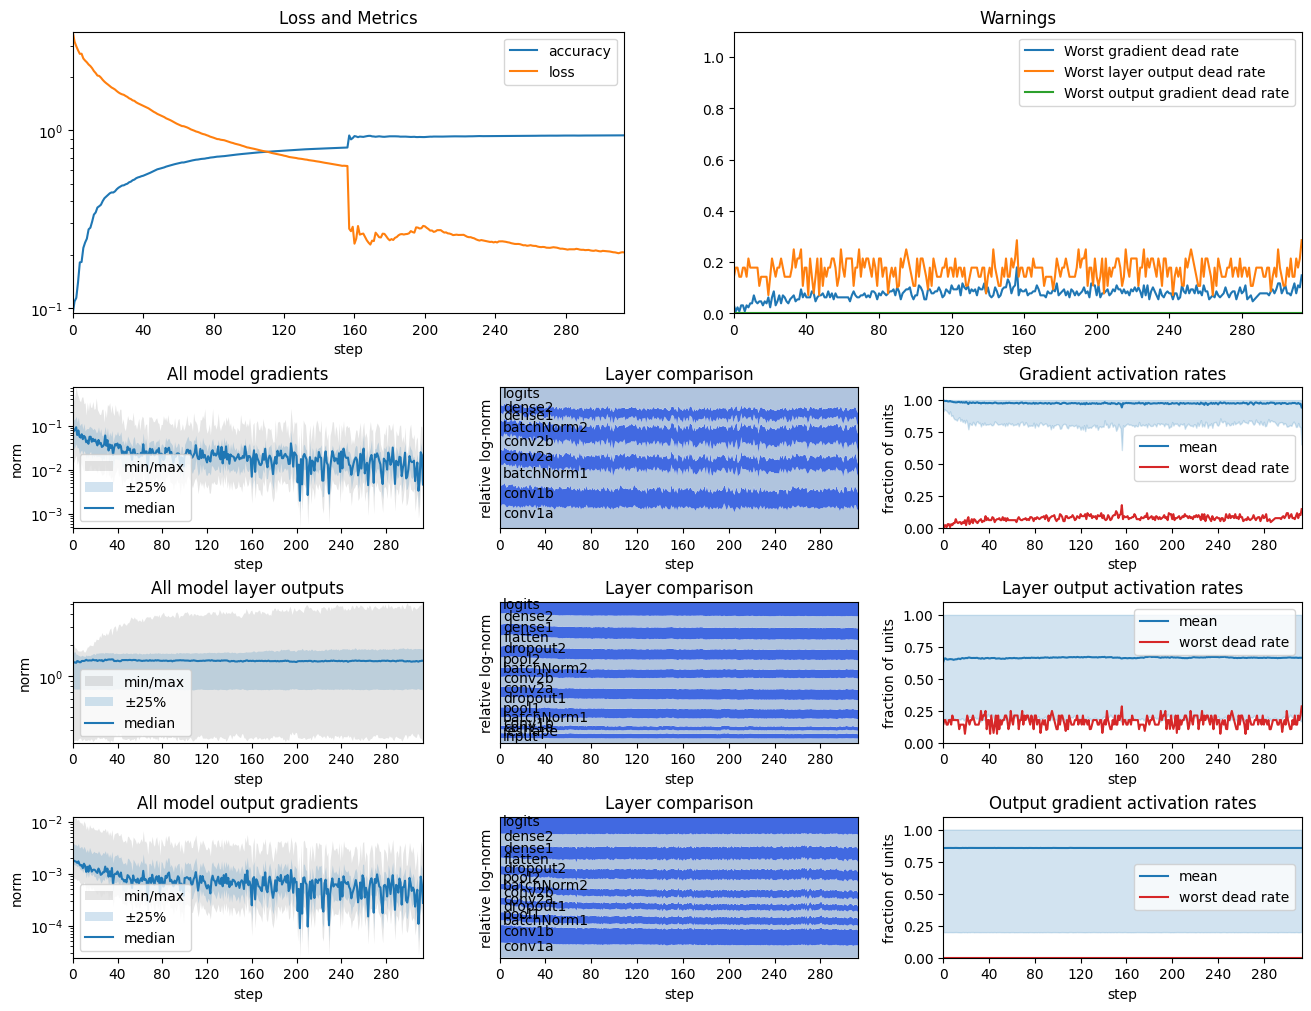

In [10]:
tinstr.plot_history_overview([mn_history, mn_gradients, mn_outputs, mn_output_gradients])

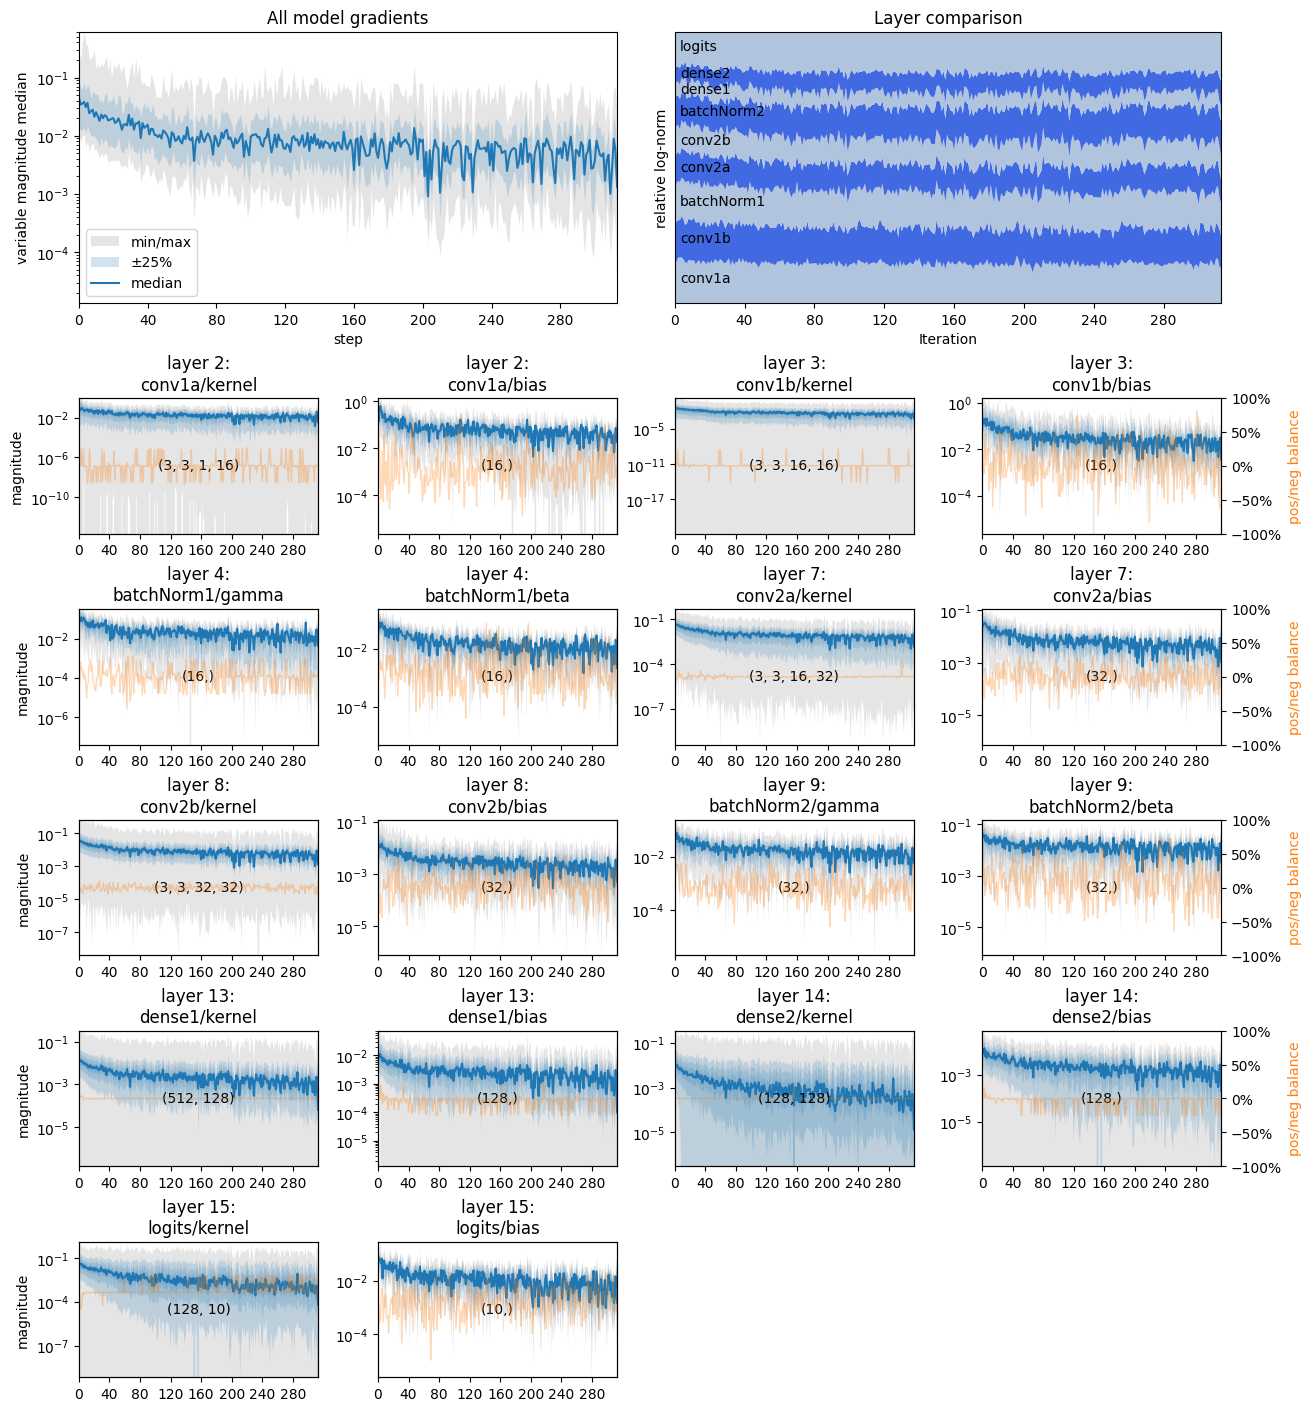

In [11]:
tinstr.plot_value_history(mn_gradients)

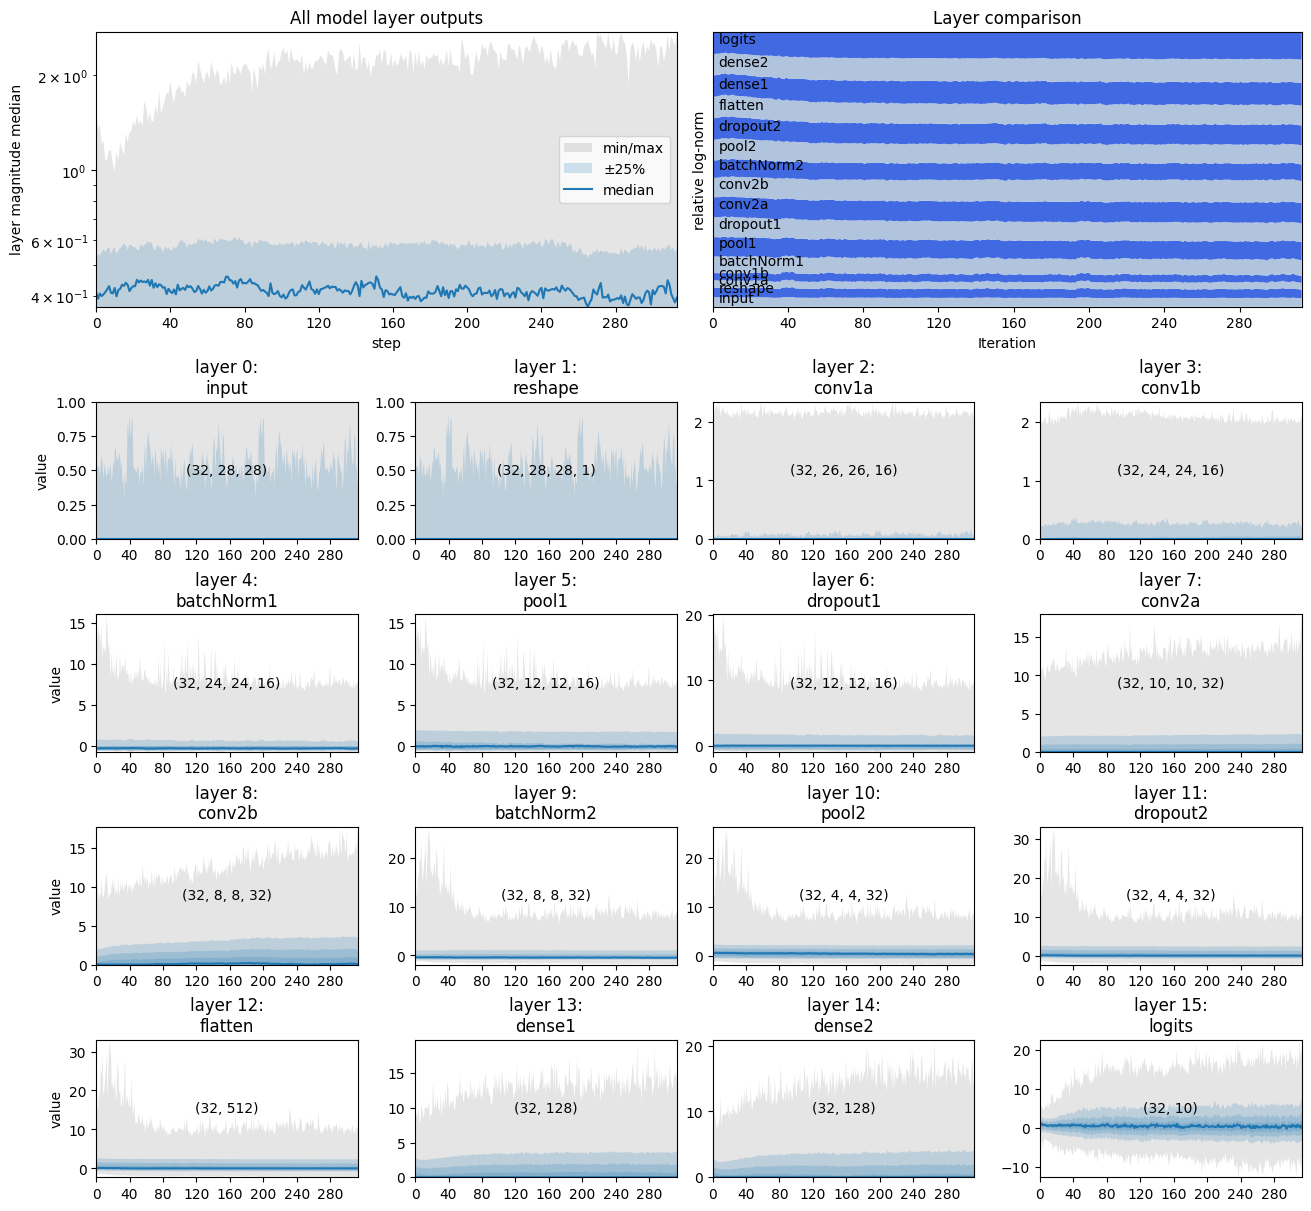

In [13]:
tinstr.plot_value_history(mn_outputs, show='values')

## Exploring distribution aggregation options

In [24]:
[len(o) if o is not None else None for o in bc_output_gradients.gradients]

[20, 20, 20, 20, 20, 20, 20, 20, None]

In [45]:
# Explore data
def summarise_layer_shape(description, model, collected_data, layer_idx):
  print(f"{description} (layer {layer_idx}): {len(collected_data[layer_idx])} x {collected_data[layer_idx][0].shape}")

def summarise_variable_shape(description, model, collected_data, layer_idx):
  var_idx = tinstr.variable_indices_by_layer(model, single=True)[layer_idx]
  print(f"{description} (layer {layer_idx}, var {var_idx}): {len(collected_data[var_idx])} x {collected_data[var_idx][0].shape}")

bc_batch_count = 10
mn_batch_count = 157
print(f"BC batches: {bc_batch_count}")
summarise_variable_shape("BC gradients", bc_gradients.model, bc_gradients.gradients, layer_idx=8)  # output layer
summarise_layer_shape("BC outputs  ", bc_outputs.model, bc_outputs.layer_outputs, layer_idx=8)  # output layer
summarise_layer_shape("BC outgrads ", bc_output_gradients.model, bc_output_gradients.gradients, layer_idx=0)  # first dense layer

print()
print(f"MN batches: {mn_batch_count}")
summarise_variable_shape("MN gradients", mn_gradients.model, mn_gradients.gradients, layer_idx=3)  # conv1a
summarise_layer_shape("MN outputs  ", mn_outputs.model, mn_outputs.layer_outputs, layer_idx=3)
summarise_layer_shape("MN outgrads ", mn_output_gradients.model, mn_output_gradients.gradients, layer_idx=3)
summarise_layer_shape("MN outputs  ", mn_outputs.model, mn_outputs.layer_outputs, layer_idx=6)  # dropout1


BC batches: 10
BC gradients (layer 8, var 24): 20 x (5, 1)
BC outputs   (layer 8): 20 x (32, 1)
BC outgrads  (layer 0): 20 x (32, 5)

MN batches: 157
MN gradients (layer 3, var 2): 314 x (3, 3, 16, 16)
MN outputs   (layer 3): 314 x (32, 24, 24, 16)
MN outgrads  (layer 3): 314 x (32, 24, 24, 16)
MN outputs   (layer 6): 314 x (32, 12, 12, 16)


In [75]:
def aggregate_dist_ideal(batches, quantiles):
  """
  batches - list of batches of shape (batch_size, ..other-dims..), where batch_size may vary from entry to entry
  Return:
    percentiles, info_dict
  """
  # concatenate into a single massize tensor
  data = np.concatenate(batches, axis=0)  # (dataset_size, ..other-dims..)
  # compute full disctribution
  percentiles = tfp.stats.percentile(data, quantiles).numpy()
  return percentiles, {'data-shape': data.shape}

def aggregate_dist_means(batches, quantiles):
  sums = None
  sum_weight = 0
  for batch in batches:
    weight = np.shape(batch)[0]
    sum_weight += weight
    percentiles = tfp.stats.percentile(batch, quantiles).numpy() * weight
    if sums is None:
      sums = percentiles
    else:
      sums += percentiles
  mean_dist = sums / sum_weight
  return mean_dist, {'weights-tot': sum_weight, 'num_batches': len(batches)}

def aggregate_dist_tdigest(batches, quantiles, useFastDigest=False):
  if useFastDigest:
    digest = fastdigest.TDigest()
  else:
    digest = tdigest.TDigest()
  for batch in batches:
    digest.batch_update(np.array(batch).flatten())
  percentiles = np.array([digest.percentile(q) for q in quantiles])
  return percentiles, {'digest': digest}

quantiles=[0, 25, 50, 75, 100]
lst = [np.zeros((32,28)), np.zeros((32,28)), np.zeros((32,28)), np.zeros((4,28))]
print(aggregate_dist_ideal(lst, quantiles))
print(aggregate_dist_means(lst, quantiles))
print(aggregate_dist_tdigest(lst, quantiles))

(array([0., 0., 0., 0., 0.]), {'data-shape': (100, 28)})
(array([0., 0., 0., 0., 0.]), {'weights-tot': 100, 'num_batches': 4})
(array([0., 0., 0., 0., 0.]), {'digest': <T-Digest: n=2800, centroids=1>})


In [77]:
# compare results
ideal_res = aggregate_dist_ideal(bc_output_gradients.gradients[0][0:bc_batch_count], quantiles)
means_res = aggregate_dist_means(bc_output_gradients.gradients[0][0:bc_batch_count], quantiles)
tdigest_res = aggregate_dist_tdigest(bc_output_gradients.gradients[0][0:bc_batch_count], quantiles)
print(ideal_res)
print(means_res)
print(tdigest_res)

(array([-0.25809342, -0.02831616, -0.00191616,  0.03195357,  0.32309896],
      dtype=float32), {'data-shape': (300, 5)})
(array([-0.15149231, -0.02885481, -0.00220996,  0.03089896,  0.11663136],
      dtype=float32), {'weights-tot': 300, 'num_batches': 10})
(array([-0.25809342, -0.02822047, -0.00188182,  0.03200327,  0.32309896]), {'digest': <T-Digest: n=1500, centroids=399>})


In [71]:
d = np.array([[10, 3, 48], [3, 3, 5], [8, 9, 7]])
digest = tdigest.TDigest()
digest.batch_update(d.flatten())
digest.percentile(23)

3.5700000000000003

In [111]:
d = np.array([[10., 3, 48], [3, 3, 5], [8, 9, 7]])
tf.histogram_fixed_width(d, value_range=(0, 50), nbins=100)

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)>

In [113]:
tf.histogram_fixed_width_bins(d, value_range=(0., 50.), nbins=100)

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Sub] name: 

## Performance impacts

Results (using second epoch for timings):

Baselines:
* No callbacks: 7ms/step, 2s/epoch
* Per-epoch TFPercentile: 8ms/step, 5s/epoch

BasicStats:
* Mean, stddev as percentiles, @tf.function: 19ms/step, 7s/epoch
* Mean, stddev of abs-log, as percentiles, @tf.function: 22ms/step, 4s/epoch

TFPercentile:
* Per-step + tensor addition w/o @tf.function:  105ms/step, 17s/epoch

TDigest:
* Standard TDigest: 36/step, inf/epoch
* FastDigest: 150ms/step, 38s/epoch

Binning:
* Simple CDF bin-counting via broadcasting, 50 bins, @tf.function: 140ms/step, 22s/epoch
* Simple CDF bin-counting via tf.scan(bins), 50 bins, @tf.function: 355ms/step, 55s/epoch

In [97]:
class TFPercentileDistCallback(tinstr.BaseGradientCallback):
  def __init__(self, quantiles=None, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.stats = None
    self.quantiles = quantiles or [0, 12.5, 25, 37.5, 50, 62.5, 75.0, 87.5, 100]

  def percentiles(self):
    return self.stats

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # init
    if self.stats is None:
      self.stats = [tfp.stats.percentile(a, self.quantiles) if a is not None else None for a in activations]

    # accumulate
    else:
      for a, stat in zip(activations, self.stats):
        if stat is not None:
          stat += tfp.stats.percentile(a, self.quantiles)

cb = TFPercentileDistCallback()
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.percentiles()

[<tf.Tensor: shape=(9,), dtype=float64, numpy=
 array([-2.76526299, -1.14842696, -0.6447702 , -0.30129136,  0.01547   ,
         0.30513039,  0.60640568,  1.09568762,  3.0909935 ])>,
 <tf.Tensor: shape=(9,), dtype=float64, numpy=
 array([-2.13619208, -1.13371952, -0.8352363 , -0.55214087, -0.24265087,
         0.0141607 ,  0.40713675,  1.04912688,  2.54409228])>,
 None]

In [199]:
class BinDistCallback(tinstr.BaseGradientCallback):
  def __init__(self, quantiles=None, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.bins = None
    self.counts = None
    self.quantiles = quantiles or [0, 12.5, 25, 37.5, 50, 62.5, 75.0, 87.5, 100]

  def percentiles(self):
    return self.counts

  @tf.function
  def _compute_counts(self, tensor, bins):
    target_reps = tf.ones([tf.rank(tensor)], dtype=tf.int32)
    target_reps = tf.concat([target_reps, [len(bins)]], axis=0)
    tensor_exp = tf.expand_dims(tensor, axis=-1)  # shape: (..t-dims.., 1)
    bin_exp = tf.reshape(bins, target_reps)  # shape: (1,...,1, nbins)
    return tf.reduce_sum(tf.cast(tensor_exp <= bin_exp, tf.int32), axis=tf.range(tf.rank(tensor)))

  @tf.function
  def _compute_counts2(self, tensor, bins):
    #lst = [tf.reduce_sum(tf.cast(tensor <= b, dtype=tf.int32)) for b in bins]
    def foo(accum, b):
      return tf.reduce_sum(tf.cast(tensor <= b, dtype=tf.int32))
    return tf.scan(foo, bins, 0)

  def _bins(self, tensor, nbins):
    return tf.cast(np.linspace(tf.reduce_min(tensor), tf.reduce_max(tensor), nbins+1), dtype=tensor.dtype)

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # init at start of training

    # init at start of epoch
    if self.bins is None:
      self.bins = [self._bins(a, 50) if a is not None else None for a in activations]

    # accumulate
    step_counts = [self._compute_counts2(a, bin) if a is not None else None for a, bin in zip(activations, self.bins)]
    if self.counts is None:
      self.counts = step_counts
    else:
      for a_idx, (a, step_count) in enumerate(zip(activations, step_counts)):
        if step_count is not None:
          self.counts[a_idx] += step_count

cb = BinDistCallback()
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.percentiles()[0]

<tf.Tensor: shape=(51,), dtype=int32, numpy=
array([   2,    2,    3,    8,   16,   21,   32,   37,   43,   50,   70,
         84,  106,  126,  159,  187,  228,  273,  323,  377,  424,  504,
        580,  651,  717,  786,  862,  931,  998, 1076, 1158, 1227, 1293,
       1358, 1419, 1471, 1519, 1574, 1612, 1660, 1689, 1708, 1727, 1743,
       1749, 1756, 1769, 1773, 1778, 1782, 1788], dtype=int32)>

In [50]:
class BasicStatsCallback(tinstr.BaseGradientCallback):
  def __init__(self, log_scale=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.log_scale = log_scale
    self.stats = None
    self._this_epoch_quantities = None
    self.epsilon = 1e-12

  def percentiles(self):
    return self.stats

  @tf.function
  def _compute_first(self, tensor):
    if self.log_scale:
      tf_eps = tf.constant(self.epsilon, dtype=tensor.dtype)
      tensor = tf.math.log(tf.abs(tensor) + tf_eps)

    new_min = tf.reduce_min(tensor)
    new_max = tf.reduce_max(tensor)
    new_sum = tf.reduce_sum(tensor)
    new_sq_sum = tf.reduce_sum(tf.square(tensor))
    new_count = tf.size(tensor)
    return new_min, new_max, new_sum, new_sq_sum, new_count

  @tf.function
  def _compute(self, tensor, cur_min, cur_max, cur_sum, cur_sq_sum, cur_count):
    # if using log scale, compute mean and stddev against log scale and convert to linear
    # only when deriving final results
    # NOTE: not correctly handling zeros yet
    if self.log_scale:
      tf_eps = tf.constant(self.epsilon, dtype=tensor.dtype)
      tensor = tf.math.log(tf.abs(tensor) + tf_eps)
    else:
      # TEMP
      tensor = tf.abs(tensor)

    new_min = tf.minimum(cur_min, tf.reduce_min(tensor))
    new_max = tf.maximum(cur_max, tf.reduce_max(tensor))
    new_sum = cur_sum + tf.reduce_sum(tensor)
    new_sq_sum = cur_sq_sum + tf.reduce_sum(tf.square(tensor))
    new_count = cur_count + tf.size(tensor)
    return new_min, new_max, new_sum, new_sq_sum, new_count

  @tf.function
  def _compute_as_percentiles(self, cur_min, cur_max, cur_sum, cur_sq_sum, cur_count):
    # calculate stddev via sqrt(E[X^2] - E[X]^2)
    cur_count = tf.cast(cur_count, dtype=cur_sum.dtype)
    x_mean = cur_sum / cur_count
    x2_mean = cur_sq_sum / cur_count
    stddev = tf.sqrt(x2_mean - tf.square(x_mean))
    percentiles = [cur_min, x_mean - stddev, x_mean, x_mean + stddev, cur_max]

    # convert back to linear scale
    # (and remove epsilon offset so that zeros end up as zeros at the end)
    if self.log_scale:
      tf_eps = tf.constant(self.epsilon, dtype=cur_sum.dtype)
      percentiles = tf.math.exp(percentiles) - tf_eps
    return tf.stack(percentiles)

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # accumulate across batches in epoch
    if batch == 0:
      self._this_epoch_quantities = [self._compute_first(a) if a is not None else None for a in activations]
    else:
      self._this_epoch_quantities = [self._compute(a, *quantities) if a is not None else None for a, quantities in zip(activations, self._this_epoch_quantities)]

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    if self.stats is None:
      self.stats = [[] if a is not None else None for a in activations]

    for l_idx in range(len(activations)):
      quantities = self._this_epoch_quantities[l_idx]
      if quantities is not None:
        self.stats[l_idx].append(self._compute_as_percentiles(*quantities))

np.random.seed(1)
cb = BasicStatsCallback(log_scale=False)
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_train_batch_end(batch=1, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_epoch_end(epoch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
print(f"linear_scale: {cb.percentiles()[0]}")

print()
cb = BasicStatsCallback(log_scale=True)
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_train_batch_end(batch=1, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_epoch_end(epoch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
print(f"log_scale: {cb.percentiles()[0]}")

linear_scale: [<tf.Tensor: shape=(5,), dtype=float64, numpy=array([-3.05376438, -0.48044677,  0.43414925,  1.34874527,  3.9586027 ])>]

log_scale: [<tf.Tensor: shape=(5,), dtype=float64, numpy=
array([8.03017812e-04, 1.68903571e-01, 5.23918991e-01, 1.62513503e+00,
       3.25303423e+00])>]


In [206]:
class TDigestDistCallback(tinstr.BaseGradientCallback):
  def __init__(self, quantiles=None, implementation='tdigest', *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.digests = None
    self.implementation = implementation
    self.quantiles = quantiles or [0, 12.5, 25, 37.5, 50, 62.5, 75.0, 87.5, 100]

  def percentiles(self):
    def to_percentiles(digest):
      return np.array([digest.percentile(q) for q in self.quantiles])

    percentiles = [
        to_percentiles(digest) if digest is not None else None
        for digest in self.digests
    ]
    return percentiles

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # init
    if self.digests is None:
      if self.implementation == 'tdigest':
        self.digests = [tdigest.TDigest() if a is not None else None for a in activations]
      elif self.implementation == 'fastdigest':
        self.digests = [fastdigest.TDigest() if a is not None else None for a in activations]
      else:
        raise ValueError(f"Unknown implementation: {self.implementation}")

    # accumulate
    for a, digest in zip(activations, self.digests):
      if digest is not None:
        digest.batch_update(np.array(a).flatten())

cb = TDigestDistCallback()
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.on_train_batch_end(batch=0, loss=1.0, gradients=None, trainable_variables=None, activations=[np.random.normal(size=(32,28)), np.random.normal(size=(4,28)), None], output_gradients=None)
cb.percentiles()

[array([-2.99833595, -1.15618351, -0.68881408, -0.32438746, -0.00980445,
         0.30395988,  0.68628021,  1.15973094,  2.87887372]),
 array([-2.36249209, -0.9898312 , -0.4995403 , -0.14846413,  0.14865243,
         0.44495078,  0.75066879,  1.2486549 ,  2.72716829]),
 None]

In [53]:
# baseline #1 - no callbacks
model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2)

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6327 - loss: 1.1821
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9309 - loss: 0.2340


In [54]:
# baseline #2 - collecting percentile stats only once per epoch
cb = tinstr.GradientHistoryCallback(activity_stats=False)

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2, callbacks=[cb])

cb.value_stats[0]

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6105 - loss: 1.2446
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9305 - loss: 0.2411


,0.0,12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0
0,-2.437676,-1.165085,-0.658969,-0.420206,-0.245193,0.017209,0.262402,0.913019,2.836743
1,-0.832731,-0.406215,-0.237915,-0.131105,-0.000190,0.147868,0.277883,0.545689,1.141539


In [52]:
dist_cb = BasicStatsCallback(log_scale=True)

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2, callbacks=[dist_cb])

dist_cb.percentiles()[0]

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5587 - loss: 1.5130
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9171 - loss: 0.2768


[<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-3.2526065e-19, -9.9573268e-13,  1.7040371e-10,  6.8846830e-06,
         1.0000000e+00], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-3.2526065e-19, -9.9573268e-13,  1.7040371e-10,  6.8846830e-06,
         1.0000000e+00], dtype=float32)>]

In [107]:
dist_cb = TFPercentileDistCallback()

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2, callbacks=[dist_cb])

dist_cb.percentiles()[0]

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.6500 - loss: 1.1144
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9285 - loss: 0.2249


<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.5058824, 1.       ], dtype=float32)>

In [100]:
dist_cb = TDigestDistCallback()

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2, callbacks=[dist_cb])

dist_cb.percentiles()

Epoch 1/2
  5/157 ━━━━━━━━━━━━━━━━━━━━ 1:31:12 36s/step - accuracy: 0.1316 - loss: 3.1666

KeyboardInterrupt: 

In [201]:
dist_cb = TDigestDistCallback(implementation='fastdigest')

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2, callbacks=[dist_cb])

dist_cb.percentiles()[0]

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.6378 - loss: 1.2311
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.9312 - loss: 0.2217


array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.5588256, 1.       ])

In [200]:
dist_cb = BinDistCallback()

model = mnist_classification_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
x_train, y_train = mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
history = tinstr.fit(model, train_dataset, epochs=2, callbacks=[dist_cb])

dist_cb.percentiles()[0]

Epoch 1/2
  1/157 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - accuracy: 0.0938 - loss: 3.3340

157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.6047 - loss: 1.2155
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 355ms/step - accuracy: 0.9269 - loss: 0.2581


<tf.Tensor: shape=(51,), dtype=int32, numpy=
array([6343682, 6371852, 6402250, 6429094, 6453836, 6477204, 6499970,
       6518634, 6537292, 6555534, 6572854, 6592706, 6609888, 6630128,
       6644548, 6658750, 6672600, 6691916, 6704640, 6719300, 6732650,
       6749852, 6764310, 6779942, 6793586, 6807412, 6830910, 6844132,
       6860770, 6875136, 6890086, 6907226, 6922042, 6936438, 6955262,
       6969138, 6984278, 6998588, 7019348, 7037952, 7055212, 7074756,
       7094272, 7113062, 7133752, 7157568, 7183588, 7207660, 7237312,
       7268056, 7840000], dtype=int32)>

In [202]:
digest = fastdigest.TDigest()

In [204]:
digest.from_values


<function TDigest.from_values(values, max_centroids=Ellipsis)>

### Discussion
All of the approaches that attempt to calculate actual percentile descributions are just too slow. It turns out that the TFP percentile() function is the fastest of the lot, but it's still adds 140ms/step to a loop that would otherwise be about 8ms/step. That's just too much to pay.

Options:
1. Restrict to stats from just one epoch.
2. Calculate mean and stddev instead.

For option 1, the problem is that it's cleanest to pick the last batch, but it's the worst of the lot because it's often smaller than the best. So I have to calculate against, say, the first batch. But that's also crap, because it's the first of many mini-batch updates, and so it's old news by the end of the epoch. That's fine on its own, but it's inconsistent with everything else. The elephant in the room is the stability issues - I'm directly exposed to the per-batch variability, with no way of being able to measure the level of noise.

For option 2, the most obvious problem is the accuracy. Most of the disributions are far from guassion, so stddev is not a good measure. In particular, the distributions are often different on either side of the mean, but I can find no way to calculate separate +/- stddevs. The best options it to calculate naive mean/stdev for parameters and layer outputs, and calculate log-scaled mean/stddev for gradients. For simplicity I'd probably turn all that into percentile disctributions. It's not accurate, but neither is calculating actual distributions from a single batch.

Conclusion:
* Option 2 is arguably more accurate than option 1, while being extremely efficient to compute.
* Option 2 has also prove to add hardly any time: 8ms/step to 22ms/step, compared to the other options. So adding this may even _improve_ performance relatie to a training loop that uses the current implementation which calculates a full discribution each epoch.